In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy
import observations.dimensions.two.sampling as observe
import matplotlib.pyplot as plt

from defaults.plot import *

Now we look at the joint distribution based on the marginals

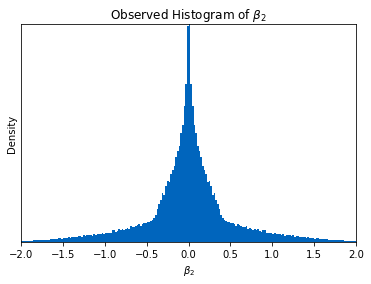

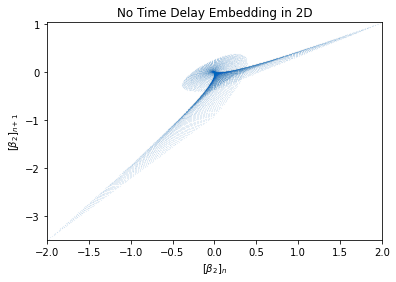

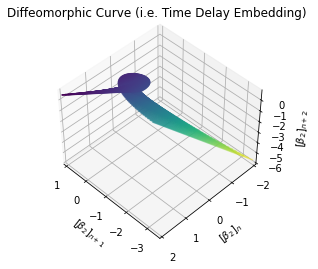

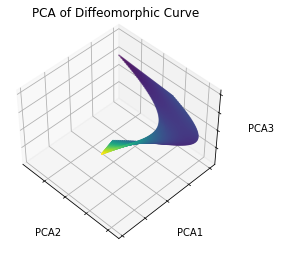

In [2]:
#beta_2s = observe.sample_beta_2(samplesizex=300, samplesizey=300)
beta_2s = observe.sample_beta_2()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(beta_2s)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_fit = scaler.fit_transform(data)

plt.hist(numpy.transpose(beta_2s)[0], bins=200, density=True, rasterized=True)
plt.title(r"Observed Histogram of $\beta_2$")
plt.xlabel(r"$\beta_2$")
plt.ylabel("Density")
no_axis(x=True)
#plt.savefig("figures/2d-marginal/density-beta2.pdf", dpi=dpi)
plt.show()

plt.scatter(numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[1], s = 0.001, rasterized=True)
plt.title("No Time Delay Embedding in 2D")
plt.xlabel(r"$[\beta_2]_{n}$")
plt.ylabel(r"$[\beta_2]_{n+1}$")
#plt.savefig("figures/2d-marginal/diffeomorphic-no.pdf", dpi=dpi)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(beta_2s)[1], numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[2], cmap='viridis', c=numpy.transpose(data_fit)[0], s = 0.5, rasterized=True)
plt.title("Diffeomorphic Curve (i.e. Time Delay Embedding)")
ax.set_xlabel(r"$[\beta_2]_{n+1}$")
ax.set_ylabel(r"$[\beta_2]_{n}$")
ax.set_zlabel(r"$[\beta_2]_{n+2}$")
ax.azim = 135
ax.elev = 45
#plt.savefig("figures/2d-marginal/diffeomorphic.pdf", dpi=dpi)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(data)[1], numpy.transpose(data)[0], numpy.transpose(data)[2], s = 0.5, cmap='viridis', c=numpy.transpose(data_fit)[0], rasterized=True)
plt.title("PCA of Diffeomorphic Curve")
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.azim = 135
ax.elev = 45
#plt.savefig("figures/2d-marginal/diffeomorphic-PCA.pdf", dpi=dpi)
plt.show()

In [3]:
%%time

import datafold.pcfold as pfold

X_pcm = pfold.PCManifold(data_fit)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.01772757959852209, cut-off=0.5714491089741751
Wall time: 1.07 s


TODO:!! make second plot from other diffusion map?
Found parsimonious eigenvectors (indices): [1 5]
Wall time: 1min 19s


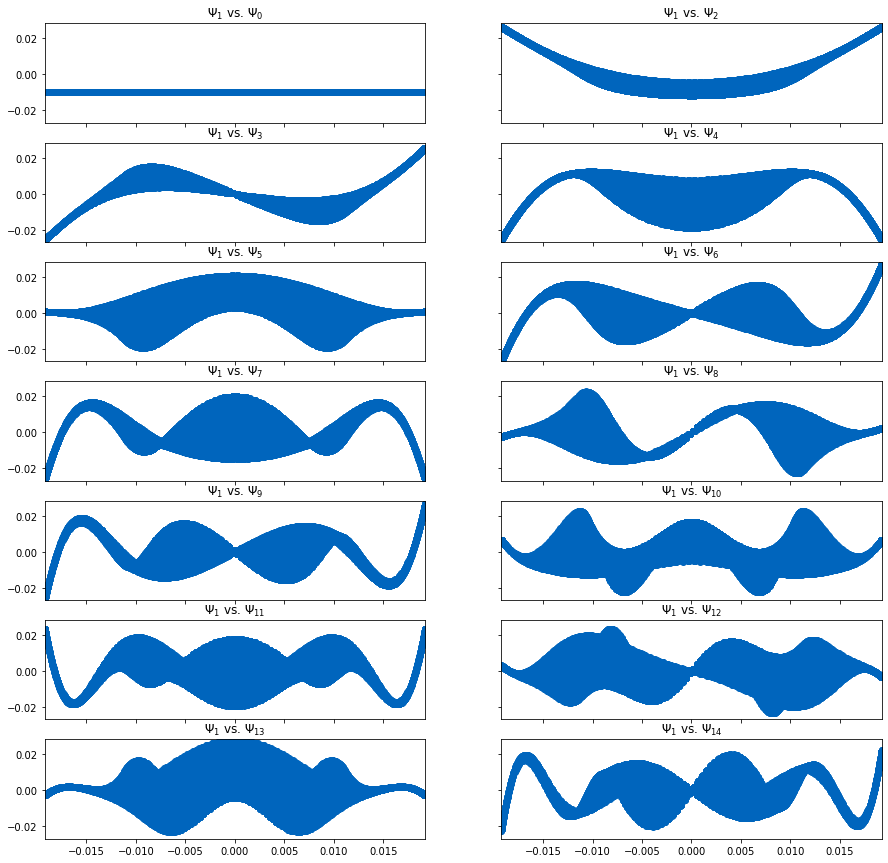

In [4]:
%%time

import datafold.dynfold as dfold

num_eigenpairs = 15

# TODO: also show this plot
print("TODO:!! make second plot from other diffusion map?")
#dmap = dfold.DiffusionMaps(
#    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
#    n_eigenpairs=15,
#    dist_kwargs=dict(cut_off=X_pcm.cut_off),
#)
dmap = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(k_neighbor=150, delta=1.0),
    n_eigenpairs=num_eigenpairs
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

from datafold.utils.plot import plot_pairwise_eigenvector

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral),
)

from datafold.dynfold import LocalRegressionSelection

selection = LocalRegressionSelection(
    intrinsic_dim=2, n_subsample=2500, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

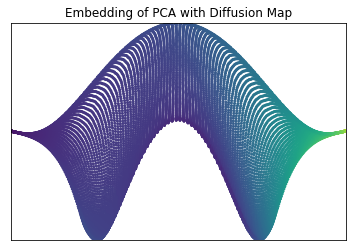

In [5]:
# Should be the same as evecs[:, selection.evec_indices_]
target_mapping = selection.transform(dmap.eigenvectors_)

_, ax = plt.subplots()
plt.title("Embedding of PCA with Diffusion Map")
ax.scatter(
    target_mapping[:, 0],
    target_mapping[:, 1],
    cmap='viridis',
    c=numpy.transpose(data_fit)[0],
    s=4,
    rasterized=True,
)
#plt.xlabel("$\Psi_1$")
#plt.ylabel("$\Psi_2$")
no_axis()
plt.savefig("figures/2d-marginal/embedding-dmap.pdf", dpi=dpi * 2 / 3)
plt.show()

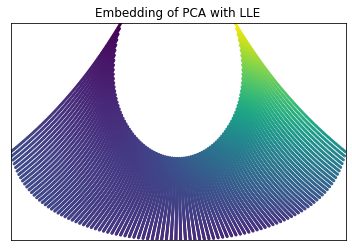

Wall time: 1.62 s


In [6]:
%%time

from functools import partial
from sklearn import manifold

LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors=10, n_components=2, eigen_solver='auto')

Y = LLE(method="standard").fit_transform(data_fit)

#Y = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(data_fit)
#Y = manifold.MDS(n_components=2, max_iter=100, n_init=1).fit_transform(data_fit)
_, ax = plt.subplots()
plt.title("Embedding of PCA with LLE")
ax.scatter(Y[:, 0], Y[:, 1], cmap='viridis', c=numpy.transpose(data_fit)[0], s=4, rasterized=True)
no_axis()
plt.savefig("figures/2d-marginal/embedding-LLE.pdf", dpi=dpi * 2 / 3)
plt.show()

In [7]:
%%time
import torch
import flows.utils as flows

flow_dist, spline_transform = flows.normal2d_to_samples(torch.tensor(target_mapping, dtype=torch.float), steps=3001, normalize=True)

C:\Users\plain\Dropbox\university\21SS\IN2261 Bachelor's Thesis\code\demos\flows\utils.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float)


step: 0, loss: -3.2413523197174072
step: 200, loss: -6.869257926940918
step: 400, loss: -7.297025203704834
step: 600, loss: -7.3274006843566895
step: 800, loss: -7.395893096923828
step: 1000, loss: -7.530488967895508
step: 1200, loss: -7.567795276641846
step: 1400, loss: -7.588352203369141
step: 1600, loss: -7.620945453643799
step: 1800, loss: -7.640417098999023
step: 2000, loss: -7.67847204208374
step: 2200, loss: -7.521345138549805
step: 2400, loss: -7.650811672210693
step: 2600, loss: -7.599426746368408
step: 2800, loss: -7.702535152435303
step: 3000, loss: -7.6818318367004395
Wall time: 1min 59s


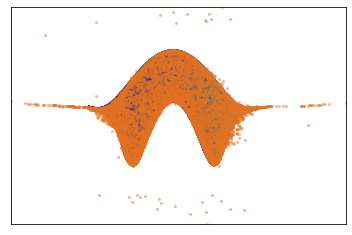

In [8]:
X_flow = flow_dist.sample(torch.Size([10000,])).detach().numpy()
plt.scatter(target_mapping[:, 0], target_mapping[:, 1], cmap='viridis', c=numpy.transpose(data_fit)[0], s=4, rasterized=True)
plt.scatter(X_flow[:, 0], X_flow[:,1], alpha=0.4, s=4, rasterized=True, c=TUMAccentOrange)
no_axis()
plt.savefig("figures/2d-marginal/density-dmap-nf.pdf", dpi=dpi)
plt.show()

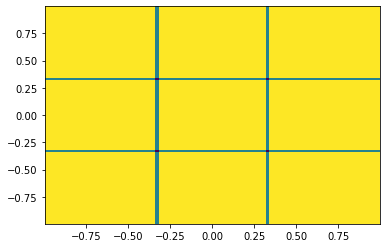

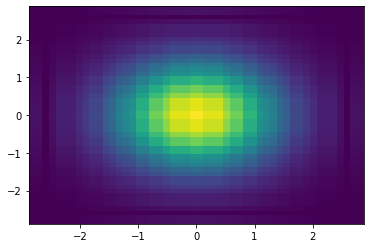

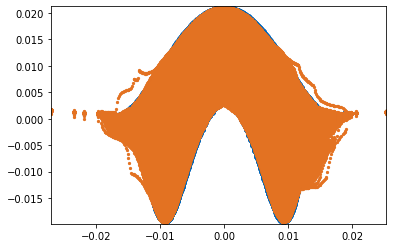

In [9]:
from scipy.special import erfinv
Gauss = lambda x, mu, sigma: mu + numpy.sqrt(2)*sigma*erfinv(2*x-1)
standard_gauss = numpy.vectorize(lambda x: Gauss((x + 1) / 2, 0, 1)) # multiple with 2 subtract one to transport 0 - 1 to -1, 1


x_linespace = numpy.linspace(-1, 1, observe.samplesizex*5)[1:-1]
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey*5)[1:-1]
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)

plt.hist2d(X.reshape(-1), beta_1.reshape(-1), bins=100)
plt.show()

normal_X, normal_beta_1 = numpy.meshgrid(standard_gauss(x_linespace), standard_gauss(beta_1_linespace))
plt.hist2d(normal_X.reshape(-1), normal_beta_1.reshape(-1), bins=50, density=True)
plt.show()

point_tuples = numpy.array((X, beta_1)).reshape(2,-1).T
normal_point_tuples = numpy.array((normal_X, normal_beta_1)).reshape(2,-1).T#numpy.vstack([X.ravel(), beta_1.ravel()])
parameterized_space = spline_transform(torch.tensor(normal_point_tuples, dtype=torch.float)).detach().numpy()

plt.scatter(target_mapping[:, 0], target_mapping[:, 1])
plt.scatter(parameterized_space[:, 0], parameterized_space[:, 1], s=5, alpha=1)
plt.show()

In [15]:
%%time

from sklearn.model_selection import cross_val_score, train_test_split
from datafold.dynfold import (
    GeometricHarmonicsInterpolator as GHI,
    LocalRegressionSelection,
)

import pandas as pd
# Ok, now we have transformed a uniform distribution to the embedded space
# We can now reconstruct the fold by learning a way back from this embedding into the original space
# (could have been immediately)
random_state = 42

X_all = data_fit
psi_all = target_mapping

# shuffle new training and test set
X_train, X_test, psi_train, psi_test = train_test_split(
    X_all, psi_all, train_size=2 / 3, random_state=random_state
)

# (!!) we use the DMAP space as base space now, and interpolate X as function values
pcm = pfold.PCManifold(psi_train)
pcm.optimize_parameters(random_state=random_state)

opt_epsilon = pcm.kernel.epsilon
opt_cutoff = pcm.cut_off
opt_n_eigenpairs = 500

# good ones are epsilon=1.2931307914077133e-07, cut-off=0.0015433842512056403
print(f"epsilon={opt_epsilon}, cut-off={opt_cutoff}")

# test the interpolation quality with PCManifold optimization
gh_interpolant_psi_to_X = GHI(
    #pfold.ContinuousNNKernel(k_neighbor=125, delta=1.0),
    pfold.GaussianKernel(epsilon=opt_epsilon),
    n_eigenpairs=opt_n_eigenpairs,
    dist_kwargs=dict(cut_off=opt_cutoff),
)

gh_interpolant_psi_to_X.fit(psi_train, X_train)

# compute residual and error
residual = gh_interpolant_psi_to_X.score(psi_train, X_train)
error = gh_interpolant_psi_to_X.score(psi_test, X_test)

pd.DataFrame(
    numpy.row_stack([residual, error]),
    index=["residual", "error"],
    columns=["x", "y", "z"],
)

epsilon=1.2076236893222164e-07, cut-off=0.0014914841749022504
Wall time: 16.6 s


,x,y,z
residual,-0.147602,-0.133837,-0.191742
error,-0.209252,-0.179526,-0.253155


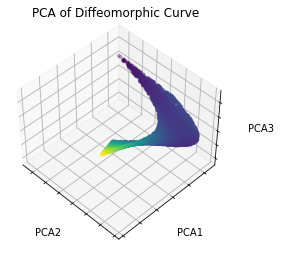

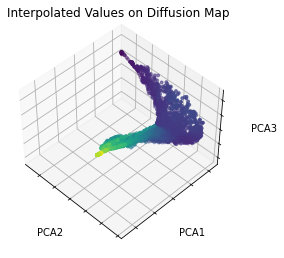

In [16]:
def plot_dmap_comparison(postfix, interpolator):
    # plot ground truth and interpolated values
    ax = plt.axes(projection ='3d')
    ax.scatter(X_test[:, 1], X_test[:, 0], X_test[:, 2], cmap='viridis', c=numpy.transpose(X_test)[0], s=8, rasterized=True)
    ax.set_title("PCA of Diffeomorphic Curve")
    ax.set_xlabel("PCA2")
    ax.set_ylabel("PCA1")
    ax.set_zlabel("PCA3")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.grid(True)
    ax.azim = 135
    ax.elev = 45
    plt.savefig("figures/2d-marginal/preimage-truth-" + postfix + ".pdf", dpi=dpi)
    plt.show()

    ax = plt.axes(projection ='3d')
    x,y,z = interpolator.predict(psi_test).T
    ax.scatter(
        y, x, z, cmap='viridis', c=numpy.transpose(X_test)[0], s=8, rasterized=True
    )
    ax.set_title("Interpolated Values on Diffusion Map")
    ax.set_xlabel("PCA2")
    ax.set_ylabel("PCA1")
    ax.set_zlabel("PCA3")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.grid(True)
    ax.azim = 135
    ax.elev = 45
    plt.savefig("figures/2d-marginal/preimage-" + postfix + ".pdf", dpi=dpi)
    plt.show()

plot_dmap_comparison("quick", gh_interpolant_psi_to_X)

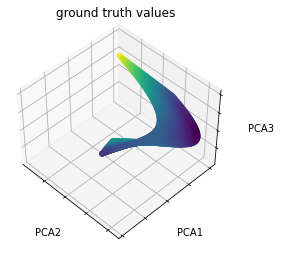

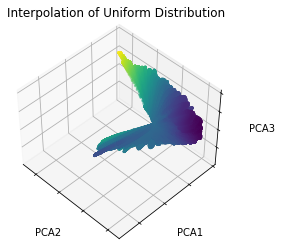

In [17]:
# We can now interpolate in our psi space and can transform our unfirom -> NF to parameterization -> 3d space

ax = plt.axes(projection ='3d')
ax.scatter(data[:, 1], data[:, 0], data[:, 2], c=numpy.transpose(data_fit)[1], cmap='viridis')
ax.set_title("ground truth values")
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(True)
ax.azim = 135
ax.elev = 45
plt.show()

#new_pca_normalized = optimal_GHI.predict(parameterized_space)
new_pca_normalized = gh_interpolant_psi_to_X.predict(parameterized_space)
new_pca = scaler.inverse_transform(new_pca_normalized)
ax = plt.axes(projection ='3d')
ax.scatter(new_pca[:, 1], new_pca[:, 0], new_pca[:, 2], c=numpy.transpose(new_pca)[1], cmap='viridis', s=4, rasterized=True)
ax.set_title("Interpolation of Uniform Distribution")
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(True)
ax.azim = 135
ax.elev = 45
plt.savefig("figures/2d-marginal/uniform-pca.pdf", dpi=dpi)
plt.show()

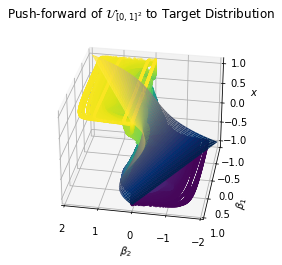

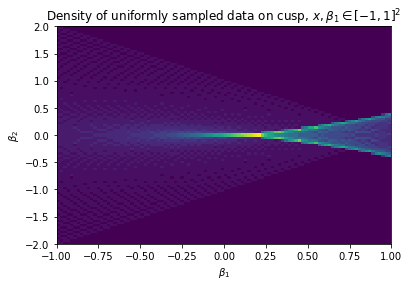

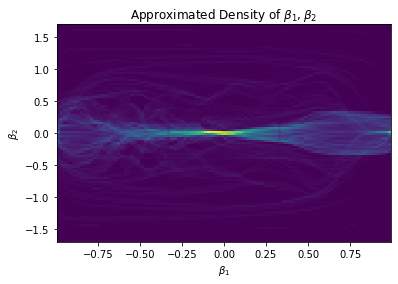

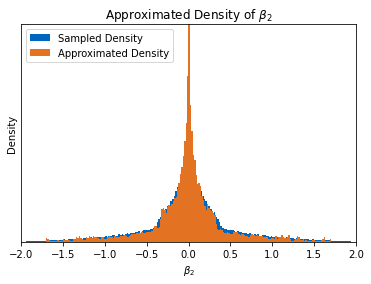

In [21]:
new = pca.inverse_transform(new_pca)

reconstructed_cusp = numpy.append(point_tuples, new[:,0].reshape(-1, 1), axis=1)
def draw_cusp():
    x_linespace = numpy.linspace(-1, 1, observe.samplesizex)
    beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey)
    X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)
    beta_2 = observe.cusp_vectorized(X, beta_1)

    ax = plt.axes(projection ='3d')
    ax.set_title(r'Push-forward of $\mathcal{U}_{[0,1]^2}$ to Target Distribution')
    ax.plot_surface(beta_2, beta_1, X, cmap='cividis', edgecolor='none', rasterized=True) #label="Real (unknown) push-forward"

    # We learned the mirrored version
    # This is something we cannot really control, if it will become flipped or not
    # We negate the values so that we look like the plot
    # Of course, if we do not know the plot we cannot do this
    ax.scatter(-reconstructed_cusp[:, 2], -reconstructed_cusp[:, 1], reconstructed_cusp[:, 0], s=4, cmap='viridis', c=reconstructed_cusp[:, 0], rasterized=True) # label="Approximated push-forward"
    ax.set_xlabel(r'$\beta_2$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_zlabel('$x$')
    ax.azim = 100
    ax.elev = 30
    plt.savefig("figures/2d-marginal/push-forward-uniform-beta2.pdf", dpi=dpi)
    plt.show()

    plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
    plt.hist2d(beta_1.reshape(-1), beta_2.reshape(-1), bins=100, density=True)
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.show()

    plt.title(r"Approximated Density of $\beta_1, \beta_2$")
    # Same here - mirrored
    plt.hist2d(-reconstructed_cusp[:, 1], -reconstructed_cusp[:, 2], bins=100, density=True, rasterized=True)
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.savefig("figures/2d-marginal/density-beta1-beta2-reconstructed.pdf", dpi=dpi)
    plt.show()

    plt.title(r"Approximated Density of $\beta_2$")
    plt.hist(numpy.transpose(beta_2s)[0], bins=200, density=True, rasterized=True, label=r"Sampled Density")
    plt.hist(-reconstructed_cusp[:, 2], bins=200, density=True, rasterized=True, label=r"Approximated Density")
    plt.xlabel(r"$\beta_2$")
    plt.ylabel("Density")
    no_axis(x=True)
    plt.legend(loc="upper left")
    plt.savefig("figures/2d-marginal/density-beta2-reconstructed.pdf", dpi=dpi)
    plt.show()

draw_cusp()